This notebook demostrates how to use ART on simulated data, where the response variable is modeled using a function with 'easy' level of difficulty.

## Setup

The first step is to make sure the `ART` library is available in your kernel.

Clone the corresponding git repository:


`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.



We can then add library to the path and do the necessary import:


In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
    
from art.core import *   
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## User parameters

How many input variables (features) you would like to explore? Or what is the dimensionality of the system?

In [2]:
user_params = {'dim': 10}

Assign input and response variables:

In [3]:
input_vars = ['x_' + str(i) for i in range(1, user_params['dim'] + 1)]
response_vars = ['y']

Define the number instances for the initial DBTL cycle:

In [4]:
user_params['n_instances_cycle1'] = 100

Define the number of recommendations to be generated at each subsequent cycle:

In [5]:
user_params['num_recommendations'] = 16

Define the number of cycles you would like to perform:

In [6]:
user_params['n_cycles'] = 4

Define the exploitation-exploration parameter `alpha`. Values closer to 1 correspond to exploring regions of input phase space associated with high uncertainty, so as to obtain more data from that region and improve the model’s predictive accuracy in subsequent cycles. Values closer to 0 correspond to exploitation, i.e. optimizing the predicted value for the response variable.

In [7]:
user_params['alpha_cycle2'] = 0.9
user_params['alpha_cycle3'] = 0.5
user_params['alpha_cycle4'] = None

Define the objective for optimization and a threshold for defining success (for example, a success is 20% improvement over the best in the training data set)

In [8]:
user_params['objective'] = 'maximize'
user_params['threshold'] = 0.2

Define the output directory for storing the results and seed for random number generator for the repeatability of the run:

In [9]:
user_params['output_directory'] = '../results/'
user_params['seed'] = 42

## Define true response function

In [10]:
def true_function_easy(x, dimension):

    term1 = 0.
    term2 = 0.
    for i in range(dimension):
        term1 += (x[i] - 5)**2
        term2 += x[i]**2

    return -1*(1/dimension * term1 + np.exp(-term2)) + 25

In [11]:
dim = user_params['dim']
global_optimum_value = 25.                
global_optimum = 5.*np.ones(dim)
lb, ub = -5., 10.


### Visualize true function for 2-dimensional case

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


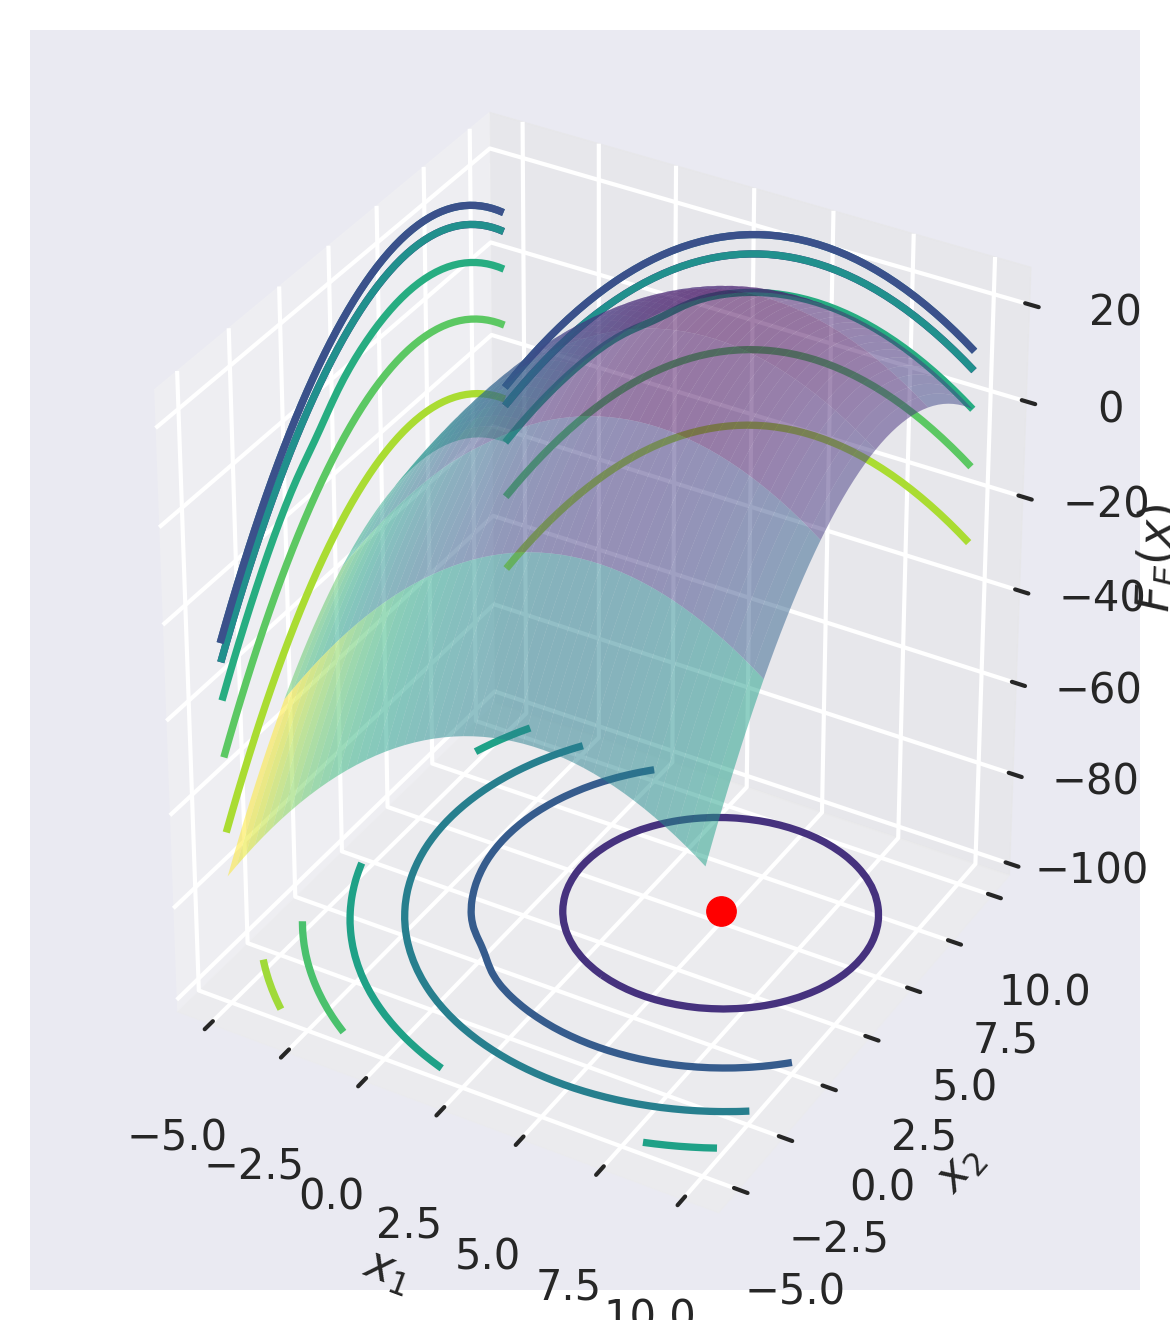

In [12]:
# Additional variables for plotting models
cmap = plt.cm.viridis_r 
n_points = 50
x1 = np.linspace(lb,ub,n_points)
x2 = np.linspace(lb,ub,n_points)
X1, Y1 = np.meshgrid(x1, x2)
dimen = 2
Z1 = true_function_easy(np.array([X1, Y1]),dimen)
f_max1 = true_function_easy([5,5],dimen)
min_z1 = -100

fig = plt.figure(figsize=(4, 4.5), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X1, Y1, Z1, rstride=10, cstride=1, cmap=cmap, alpha=0.5,edgecolor='None')
ax.scatter(5, 5, min_z1, s=50, c='r',edgecolor='r')
ax.set_zlim3d(min_z1, f_max1)
cset = ax.contour(X1, Y1, Z1, zdir='z', offset=min_z1, cmap=cmap)
cset = ax.contour(X1, Y1, Z1, zdir='x', offset=-5, cmap=cmap)
cset = ax.contour(X1, Y1, Z1, zdir='y', offset=10, cmap=cmap)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$F_E(x)$')
plt.tight_layout()


## Create file with bounds for input variables

Here we define some constraints on the input variables, for example only positive values with an upper bound.

In [13]:
bounds_file = '../data/sim_data_bounds_FE.csv'

df = pd.DataFrame(columns=['Variable', 'Min', 'Max', 'Scaling'])
df['Variable'] = ['x_' + str(i) for i in range(1, dim + 1)]
df['Min'] = lb*np.ones(dim)
df['Max'] = ub*np.ones(dim)
df['Scaling'] = np.ones(dim)
df = df.set_index('Variable')
df.to_csv(path_or_buf=bounds_file)


## Cycle 1

In [14]:
cycle = 1

Initial designs for input variables are generated using ART’s feature for generating recommendations for the initial cycle, by setting its input parameter `initial_cycle` to True. This functionality of ART relies on the Latin Hypercube method (McKay et al., 1979), which spaces out draws in a way that ensures the set of samples represents the variability of the full design space. 

#### Define a dictionary that contains the settings for ART

In [15]:
art_params = {
    'bounds_file': bounds_file,
    'input_vars': input_vars,                       
    'num_recommendations': user_params['n_instances_cycle1'],    
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': user_params['seed'],                              
    'output_directory': user_params['output_directory']  
}


#### Run ART

In [16]:
art = RecommendationEngine(**art_params)


Take a look at a few recommended designs for input variables:

In [17]:
art.recommendations.head()


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
0,5.907208,6.576535,-0.242593,6.114163,-2.848603,1.849267,6.197468,4.918893,0.769597,-2.737659
1,2.698782,-4.462857,0.685362,7.962224,8.781270,-0.858752,-1.477080,0.786529,9.343848,4.727586
2,-0.741186,9.877792,-1.024809,-3.203699,2.233067,5.918829,3.916316,9.039919,9.183203,6.209341
3,-1.900750,-0.348457,9.710673,9.015978,-1.224394,0.290745,0.948808,5.219646,1.273533,1.707213
4,5.950167,2.942013,5.725042,-3.159716,-3.227454,6.237760,9.783681,4.054161,4.061268,3.124453


Save simulated data into EDD-style files, to be used as training data for the next cycle:

In [18]:
X = art.recommendations.values
y = true_function_easy(X.T, dim).reshape(-1, 1)
training_data_file = f'../data/sim_data_FE_cycle{str(cycle + 1)}.csv'
utils.save_edd_csv(X, y, art.input_vars, training_data_file, 'y')


## Cycle 2

In [19]:
cycle += 1

#### Define a dictionary that contains the settings for ART

In [20]:
art_params = {
    'bounds_file': bounds_file,
    'input_vars': input_vars,               
    'response_vars': response_vars,
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'alpha': user_params['alpha_cycle2'],
    'num_recommendations': user_params['num_recommendations'],  
    'seed': user_params['seed'],                           
    'output_directory': user_params['output_directory']  
}


Import training data file into a pandas dataframe:

In [21]:
df = utils.load_study(data_file=training_data_file)


#### Run ART

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


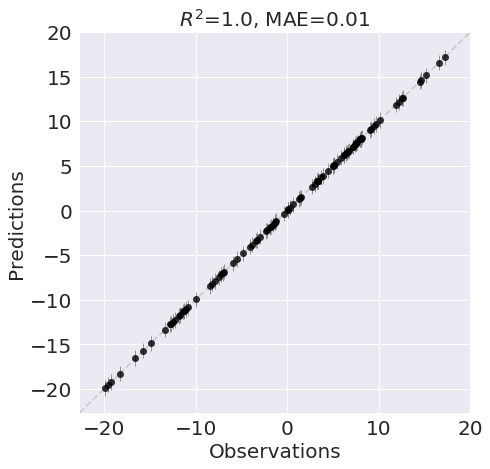

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


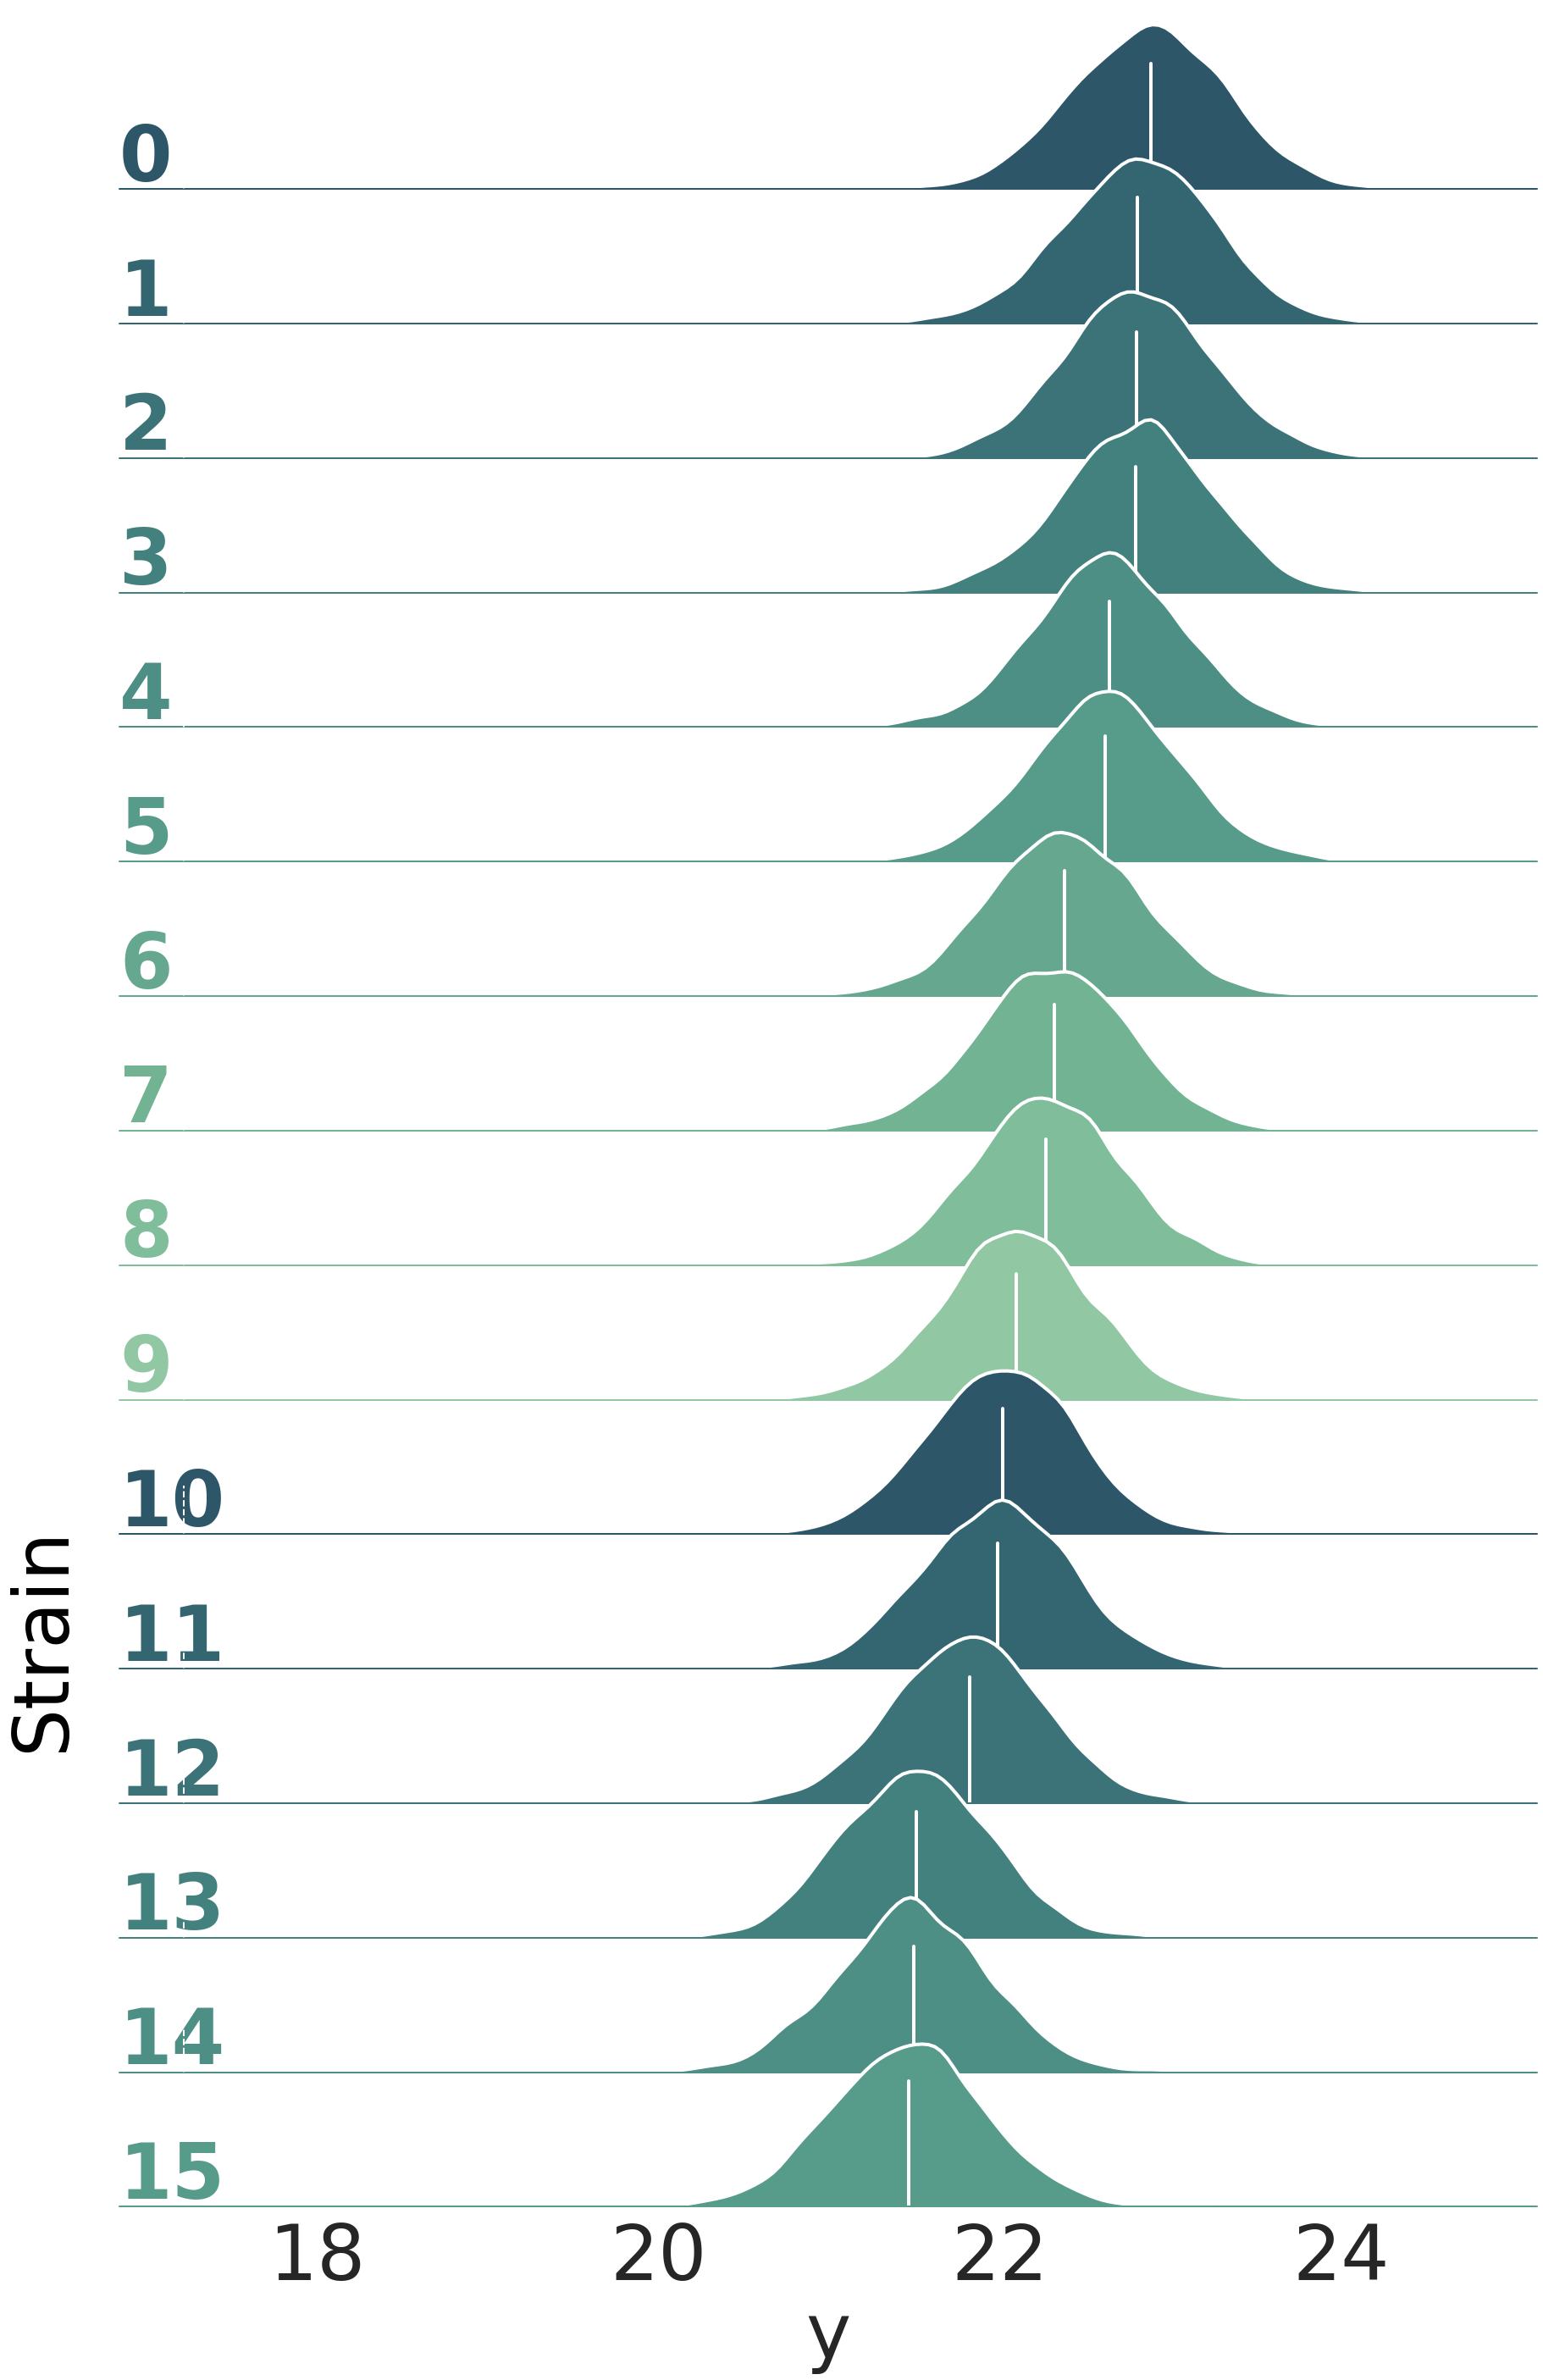

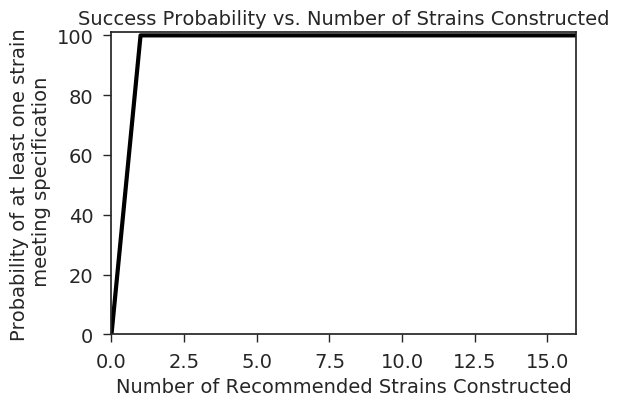

CPU times: user 4min 52s, sys: 1min 18s, total: 6min 11s
Wall time: 5min 3s


In [22]:
%%time
art = RecommendationEngine(df, **art_params)

Save recommendations for the next cycle:


In [23]:
file_path = f'{art.outDir}/recommendations_FE_cycle{str(cycle)}.csv'
art.recommendations.to_csv(path_or_buf=file_path, sep='\t')

#### Save training data for the next cycle

Input variables:

In [24]:
X_new = art.recommendations.values[:, :-1]


Simulate true values for the response variable using `true_function`:

In [25]:
y_new = true_function_easy(X_new.T, dim).reshape(-1, 1)


Save data in an EDD-style .csv file:

In [26]:
X = np.concatenate((art.X, X_new))
y = np.concatenate((art.y, y_new))
file_name = f'../data/sim_data_FE_cycle{str(cycle + 1)}.csv'
utils.save_edd_csv(X, y, art.input_vars, file_name, art.response_vars[0])


## Cycle 3

In [27]:
cycle += 1

#### Define a dictionary that contains the settings for ART

In [28]:
art_params = {
    'bounds_file': bounds_file,
    'input_vars': input_vars,               
    'response_vars': response_vars,
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'alpha': user_params['alpha_cycle3'],
    'num_recommendations': user_params['num_recommendations'],  
    'seed': user_params['seed'],                           
    'output_directory': user_params['output_directory']  
}


Import training data file into a pandas dataframe:

In [29]:
data_file = f'../data/sim_data_FE_cycle{str(cycle)}.csv'
df = utils.load_study(data_file=data_file)


#### Run ART

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 diverg

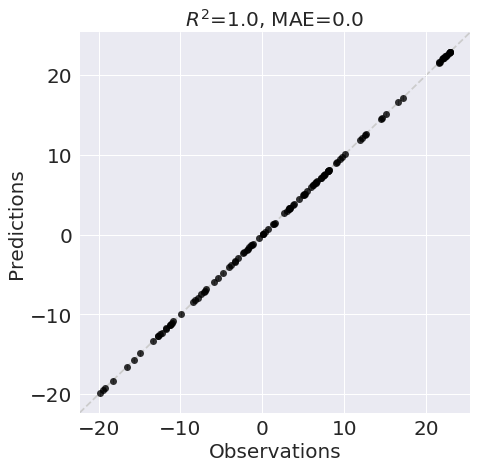

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


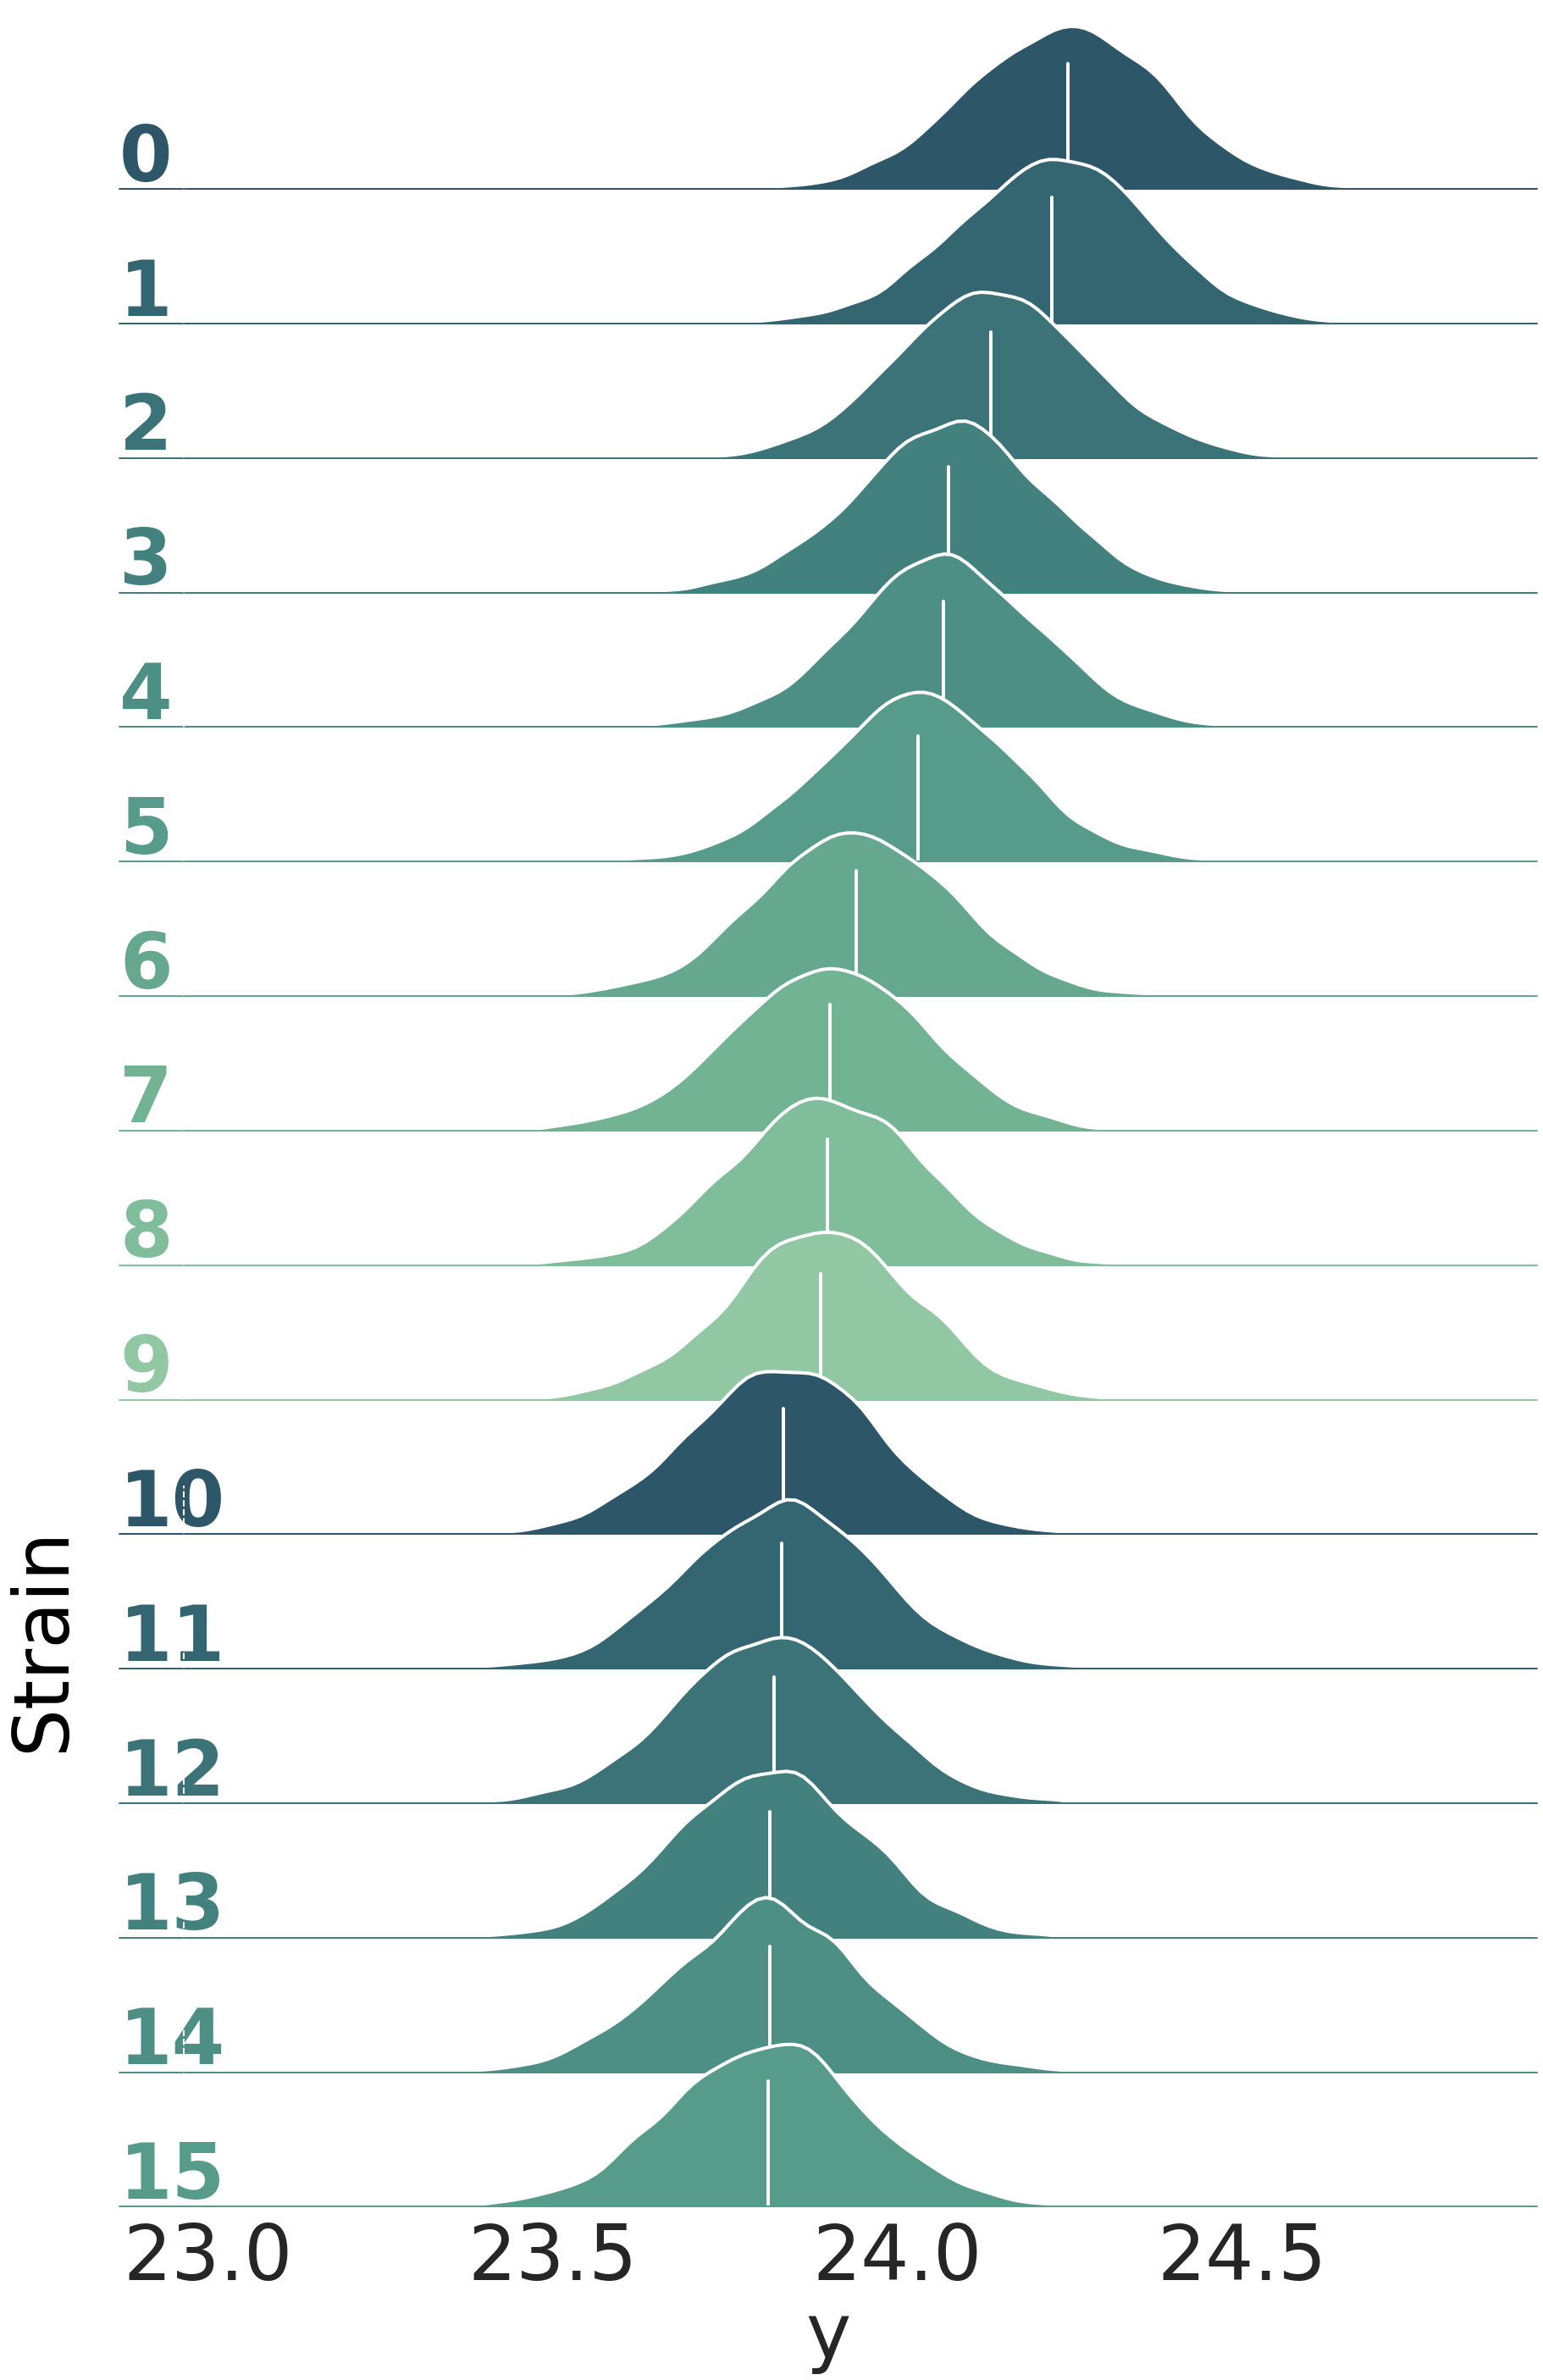

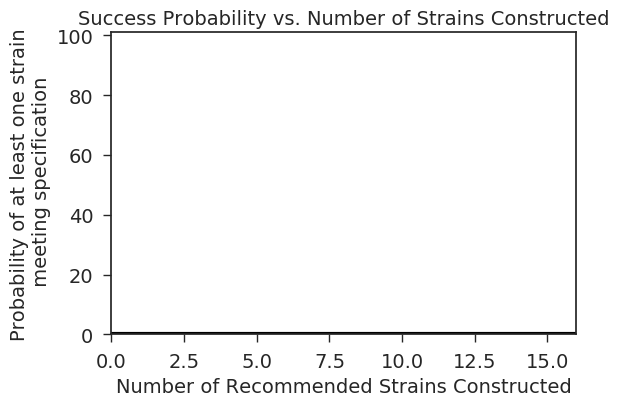

CPU times: user 5min 41s, sys: 1min 39s, total: 7min 21s
Wall time: 5min 16s


In [30]:
%%time
art = RecommendationEngine(df, **art_params)

Save recommendations for the next cycle:


In [31]:
file_path = f'{art.outDir}/recommendations_FE_cycle{str(cycle)}.csv'
art.recommendations.to_csv(path_or_buf=file_path, sep='\t')

#### Save training data for the next cycle

In [32]:
X_new = art.recommendations.values[:, :-1]
y_new = true_function_easy(X_new.T, dim).reshape(-1, 1)
X = np.concatenate((art.X, X_new))
y = np.concatenate((art.y, y_new))
file_name = f'../data/sim_data_FE_cycle{str(cycle + 1)}.csv'
utils.save_edd_csv(X, y, art.input_vars, file_name, art.response_vars[0])


## Cycle 4

In [33]:
cycle += 1

#### Define a dictionary that contains the settings for ART

In [34]:
art_params = {
    'bounds_file': bounds_file,
    'input_vars': input_vars,               
    'response_vars': response_vars,
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'alpha': user_params['alpha_cycle4'],
    'num_recommendations': user_params['num_recommendations'],  
    'seed': user_params['seed'],                           
    'output_directory': user_params['output_directory']  
}

Import training data file into a pandas dataframe:

In [35]:
data_file = f'../data/sim_data_FE_cycle{str(cycle)}.csv'
df = utils.load_study(data_file=data_file)

#### Run ART

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'c

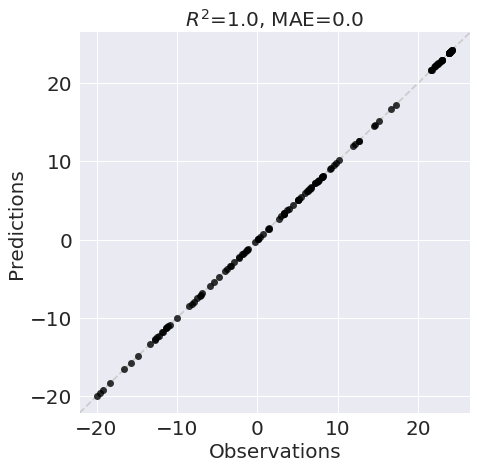

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


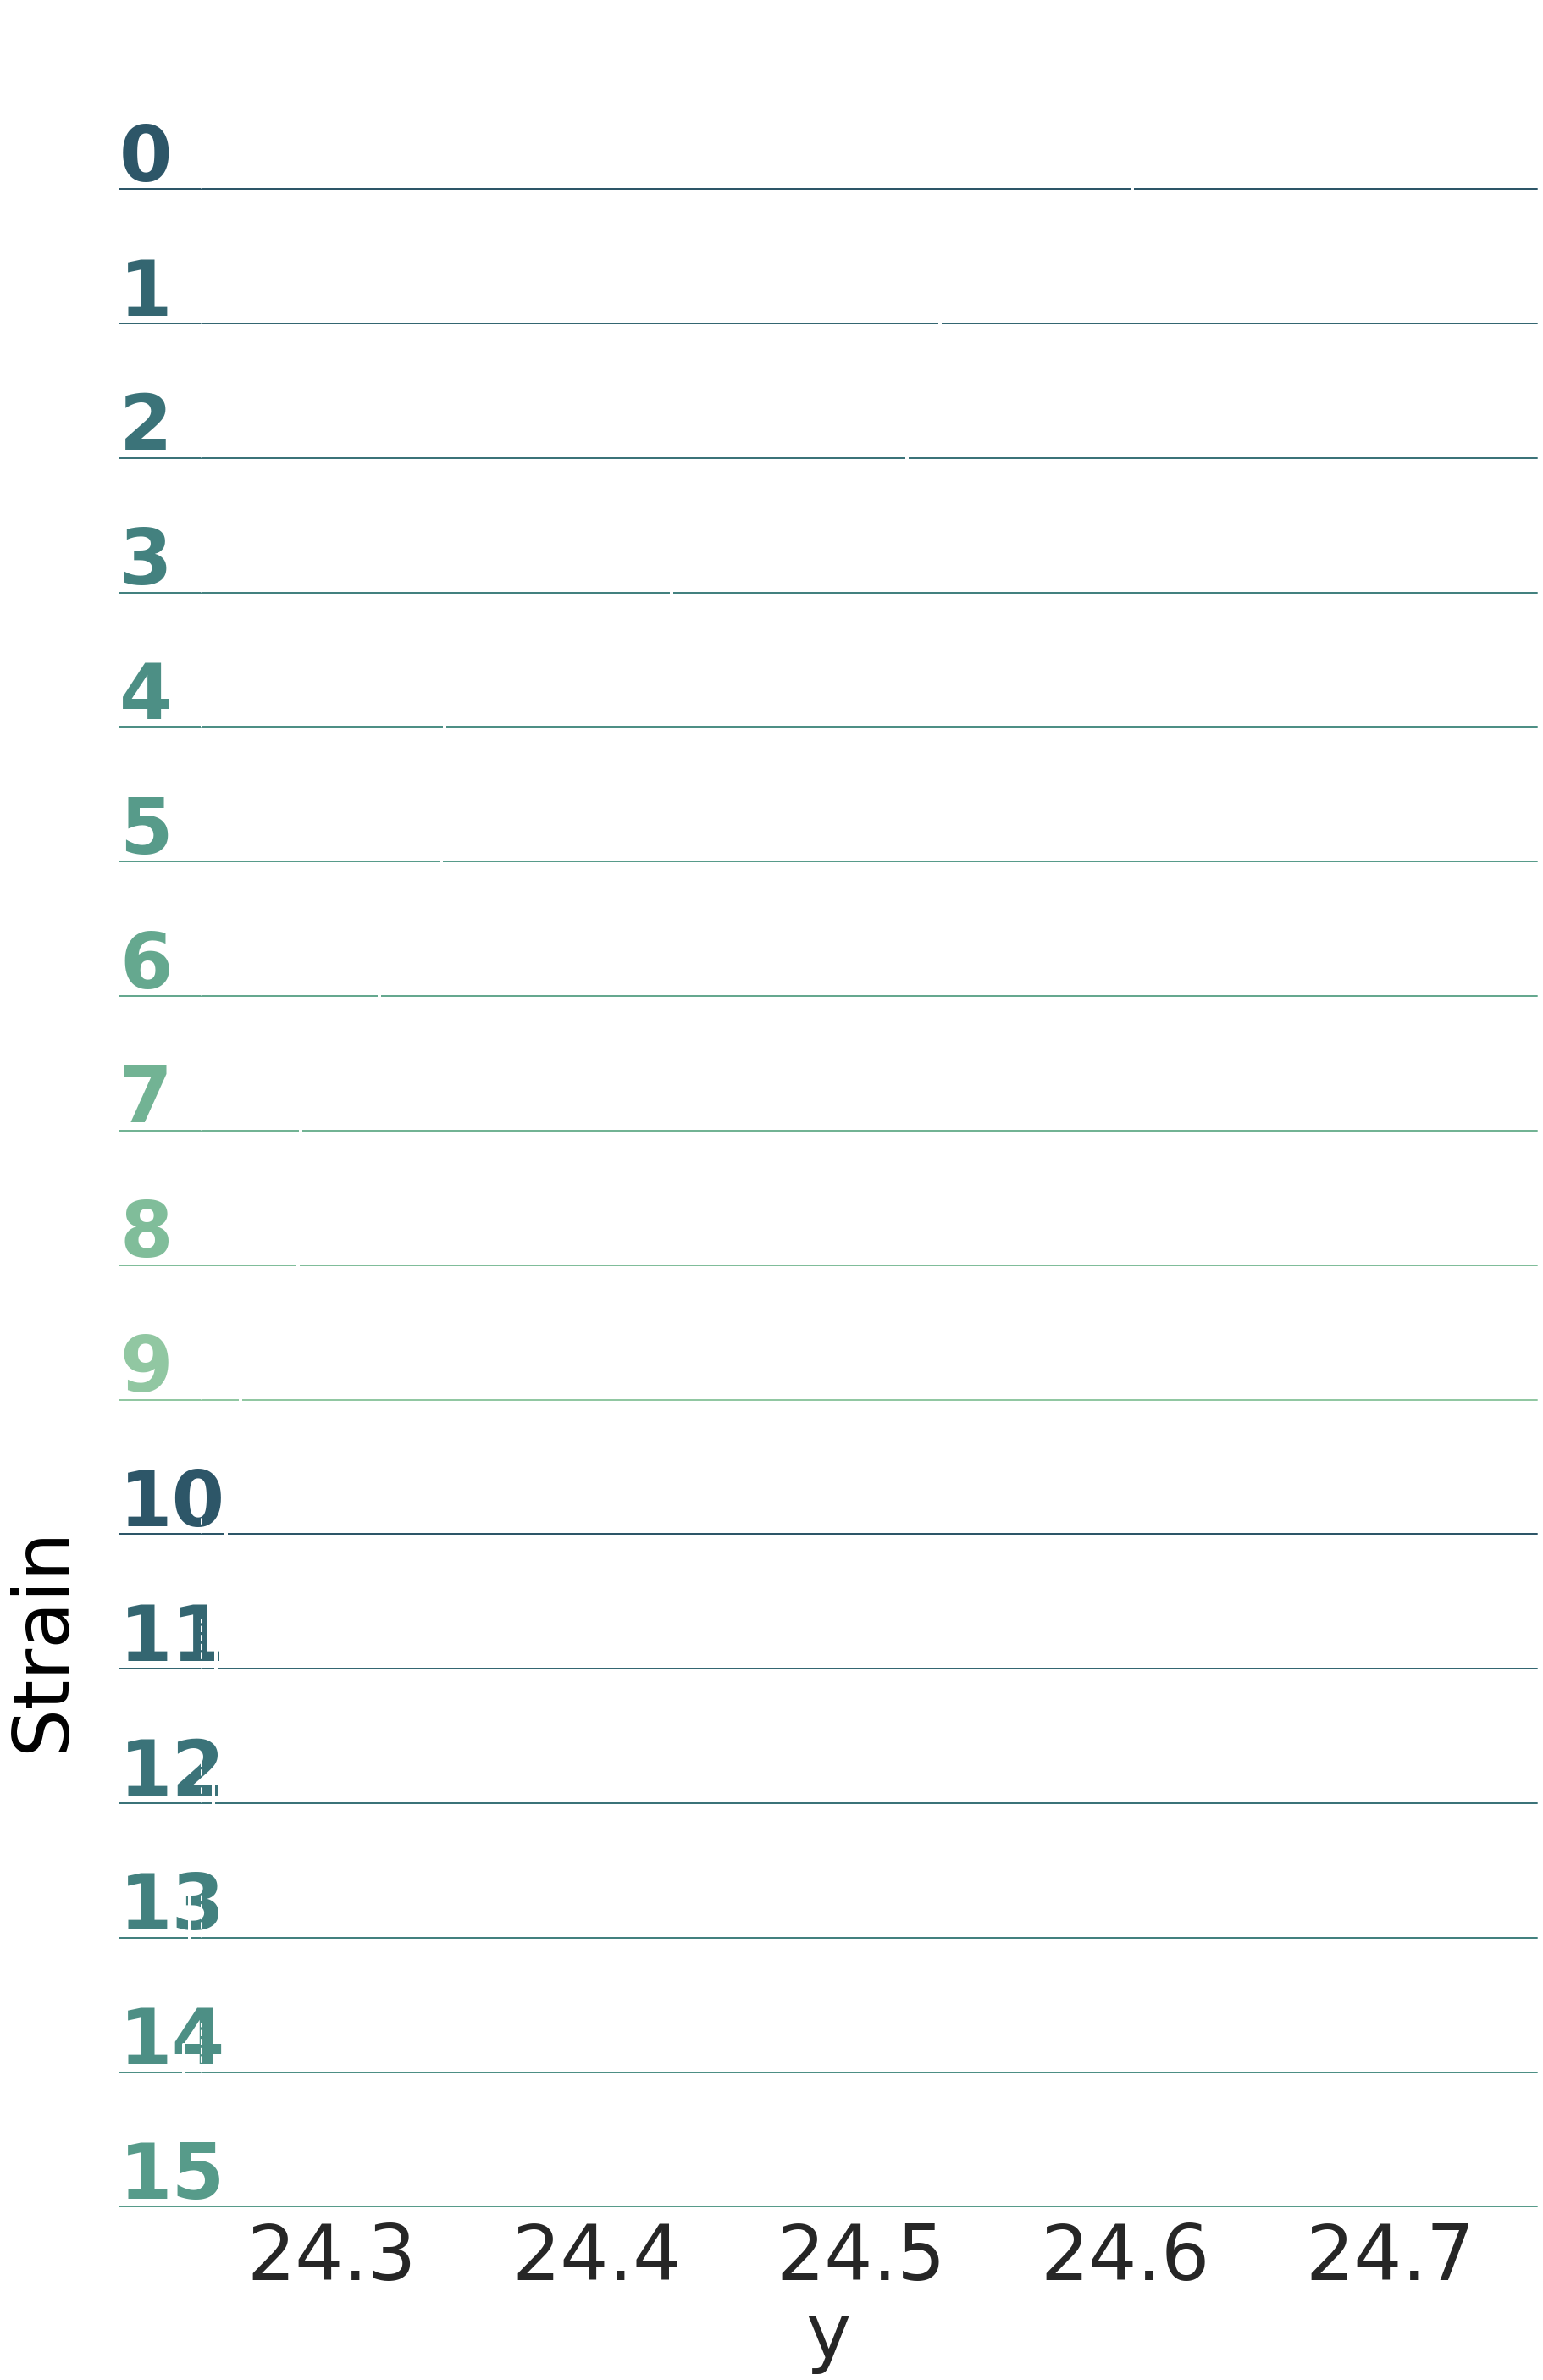

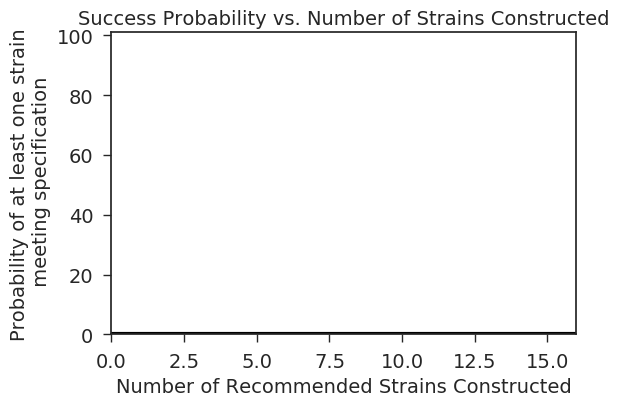

CPU times: user 7min 32s, sys: 3min 46s, total: 11min 19s
Wall time: 6min 32s


In [36]:
%%time
art = RecommendationEngine(df, **art_params)

Save recommendations for the next cycle


In [37]:
file_path = f'{art.outDir}/recommendations_FE_cycle{str(cycle)}.csv'
art.recommendations.to_csv(path_or_buf=file_path, sep='\t')